In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import ResNet50V2, VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
profiles=[
    {
        'name':'Resnet50V2',
        'base_model':ResNet50V2,
        'folder_train':'img_train',
        'folder_test':'img_test'
    },
    {
        'name':'Resnet50V2_crop',
        'base_model':ResNet50V2,
        'folder_train':'c_img_train',
        'folder_test':'c_img_test'
    },
    {
        'name':'VGG19',
        'base_model':VGG19,
        'folder_train':'img_train',
        'folder_test':'img_test'
    },
    {
        'name':'VGG19_crop',
        'base_model':VGG19,
        'folder_train':'c_img_train',
        'folder_test':'c_img_test'
    }
]

# Training
Model Structure
- Base model (ResNet50v2 or VGG19) without the top layer
  - ResNet-50: https://arxiv.org/abs/1512.03385
  - VGG19: https://arxiv.org/abs/1409.1556
- Hidden layer with 1024 nodes, with ReLu activation
- Output layer with 4 nodes corresponding to the classifications, with SoftMax activation

Training Process
- Construction of model through appending to base model
- Training only the top two layers with an SGD optimizer
  - Rough classification using feature extraction used for image classification
  - 50 epochs, but uses an early stopping mechanism that detects lack of validation loss improvement to prevent overfitting
- Training only the base model with a RMSPROP optimizer with low, decreasing learning rate
  - Fine-tunes convolutions to better suit our needs for attention classification
  - 50 epochs, but uses an early stopping mechanism that detects lack of validation loss improvement to prevent overfitting

In [ ]:
for p in profiles:
    # create the base pre-trained model
    base_name=p['name']
    print('%%%%%%%%%%%%%%{}%%%%%%%%%%%%%%'.format(base_name))
    
    base_model = p['base_model'](weights='imagenet', include_top=False)
    
    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    # and a logistic layer -- let's say we have 200 classes
    predictions = Dense(4, activation='softmax')(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    image_generator = ImageDataGenerator(rescale=1./255)
    train_img_gen=image_generator.flow_from_directory(
        directory=p['folder_train'],
        batch_size=32,
        shuffle=True,
        target_size=(224,224)
    )
    test_img_gen=image_generator.flow_from_directory(
        directory=p['folder_test'],
        batch_size=32,
        shuffle=True,
        target_size=(224,224)
    )
    
    print("---Training top layers---")
    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False

    # compile the model (should be done *after* setting layers to non-trainable)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
    
    #set callbacks - early stopping to prevent overfitting
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(filepath='./checkpoints/'+base_name+'_top/model_{epoch:02d}-{val_loss:.2f}.h5',save_best_only=True,
                                           verbose=1,restore_best_weights=True),
        #tf.keras.callbacks.EarlyStopping(patience=5)
    ]
    
    # train the model on the new data for a few epochs
    model.fit(train_img_gen,validation_data=test_img_gen,epochs=50,callbacks=callbacks,workers=8)

    model.save("models/model_{}_top_only_long.h5".format(base_name))

    pd.DataFrame(model.history.history).to_csv('logs/losses_{}_top_only.csv'.format(base_name))

    print("---Tuning base model---")
    
    for layer in model.layers[-2:]:
        layer.trainable=False
    for layer in model.layers[:-2]:
        layer.trainable=True
    
    #reset callbacks (same as last one)
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(filepath='./checkpoints/'+base_name+'_tuned/model_{epoch:02d}-{val_loss:.2f}.h5',save_best_only=True,
                                           verbose=1,restore_best_weights=True),
        tf.keras.callbacks.EarlyStopping(patience=5)
    ]

    # we need to recompile the model for these modifications to take effect
    # we use SGD with a low learning rate
    from tensorflow.keras.optimizers import SGD
    model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

    # we train our model again (this time fine-tuning the top 2 inception blocks
    # alongside the top Dense layers
    model.fit(train_img_gen,validation_data=test_img_gen,epochs=50,callbacks=callbacks,workers=8)

    model.save("models/model_{}_tuned_long.h5".format(base_name))

    pd.DataFrame(model.history.history).to_csv('logs/losses_{}_tuned.csv'.format(base_name))

# Analysis

## Comparison of Losses

In [5]:
model_names=['Resnet50V2', 'Resnet50V2_crop', 'Resnet50V2_sqr', 'Resnet50V2_no_hidden', 'Resnet50V2_sqr_no_hidden', 'VGG19', 'VGG19_crop','VGG19_sqr','VGG19_no_hidden', 'VGG19_sqr_no_hidden']
df_tops=[pd.read_csv('logs/losses_{}_top_only.csv'.format(n),index_col=0) for n in model_names]
df_bots=[pd.read_csv('logs/losses_{}_tuned.csv'.format(n),index_col=0) for n in model_names]

df_loss=pd.DataFrame({model_names[i]:pd.concat((df_tops[i].loss,df_bots[i].loss),ignore_index=True) for i in range(len(model_names))})
df_val_loss=pd.DataFrame({model_names[i]:pd.concat((df_tops[i].val_loss,df_bots[i].val_loss),ignore_index=True) for i in range(len(model_names))})

In [6]:
df_val_loss.min()

Resnet50V2                  0.383803
Resnet50V2_crop             0.445995
Resnet50V2_sqr              0.393744
Resnet50V2_no_hidden        0.269516
Resnet50V2_sqr_no_hidden    0.262821
VGG19                       0.270758
VGG19_crop                  0.354525
VGG19_sqr                   0.284432
VGG19_no_hidden             0.241978
VGG19_sqr_no_hidden         0.243538
dtype: float64

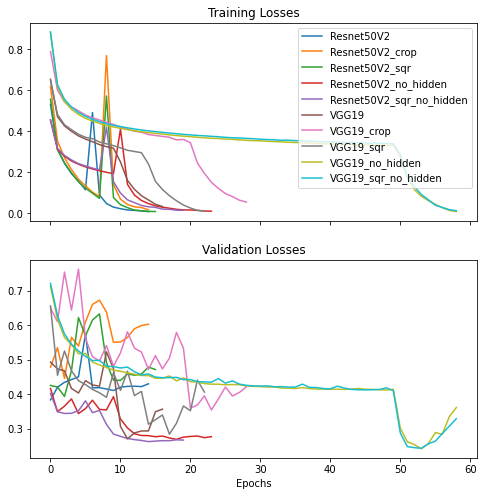

In [7]:
fig,axes=plt.subplots(2,figsize=(8,8),sharex=True)

df_loss.plot(ax=axes[0],title='Training Losses')
df_val_loss.plot(ax=axes[1],title='Validation Losses',legend=False)
axes[1].set_xlabel('Epochs')

plt.show()

The comparison of losses show that VGG19 outperforms, being a larger model than VGG19. The cropping has shown to decrease performance, which means either that a better cropping technique is needed or that one may not be helpful at all in this situation.

## Classification Analysis

In [8]:
for mn in model_names:
    #model_mn=load_model('models/model_{}_tuned_long.h5'.format(mn))
    if 'crop' in mn:
        img_dir='c_img_test'
    elif 'sqr' in mn:
        img_dir='s_img_test'
    else:
        img_dir='img_test'

    model=load_model('models/model_{}_tuned_long.h5'.format(mn))
    
    image_generator = ImageDataGenerator(rescale=1./255)
    test_img_gen=image_generator.flow_from_directory(
        directory=img_dir,
        batch_size=32,
        shuffle=True,
        target_size=(224,224)
    )
    preds=model.predict(test_img_gen)
    y_pred=np.argmax(preds,axis=1)
    y_true=test_img_gen.classes
    
    print("--- {} ---".format(mn))
    print(confusion_matrix(y_true,y_pred))
    print(classification_report(y_true,y_pred,target_names=test_img_gen.class_indices))

Found 2326 images belonging to 4 classes.


S:\conda\envs\cnn_cv\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--- Resnet50V2 ---
[[236 230 157 108]
 [249 239 132 127]
 [172 133  91  72]
 [122 122  65  71]]
              precision    recall  f1-score   support

   0_engaged       0.30      0.32      0.31       731
1_distracted       0.33      0.32      0.32       747
    2_asleep       0.20      0.19      0.20       468
    3_absent       0.19      0.19      0.19       380

    accuracy                           0.27      2326
   macro avg       0.26      0.26      0.26      2326
weighted avg       0.27      0.27      0.27      2326

Found 2326 images belonging to 4 classes.
--- Resnet50V2_crop ---
[[233 246 141 111]
 [259 238 136 114]
 [155 143  94  76]
 [113 129  61  77]]
              precision    recall  f1-score   support

   0_engaged       0.31      0.32      0.31       731
1_distracted       0.31      0.32      0.32       747
    2_asleep       0.22      0.20      0.21       468
    3_absent       0.20      0.20      0.20       380

    accuracy                           0.28      2326
